# In Class Assignment – "Behind the Scenes: Predicting Box Office Success with Random Forest"


**Dataset:** IMDB-Movie-Data.csv  
**Goal:** Predict whether a movie is a *Hit* (rating ≥ 7.0) or *Flop* using Random Forest.


## Theoretical Concept: Random Forests

### Overview
A **Random Forest** is an ensemble machine learning algorithm that combines the predictions of multiple **Decision Trees** to improve accuracy and reduce overfitting.  
Each tree in the forest is trained on a random subset of the data and features — a process called **bagging (Bootstrap Aggregating)** — which introduces diversity among trees and ensures the overall model generalizes better than any single tree.

---

### How It Works?
1. **Bootstrap Sampling:**  
   Each Decision Tree is trained on a randomly sampled subset of the original dataset (with replacement).  
   This ensures that each tree sees slightly different data, creating model diversity.

2. **Feature Randomness:**  
   At each node, a random subset of features is chosen to determine the best split instead of considering all features.  
   This prevents dominant predictors (like “Votes”) from controlling every split, improving generalization.

3. **Voting Mechanism:**  
   In classification tasks, each tree makes an independent prediction.  
   The final output of the Random Forest is decided by **majority voting** among all trees.

---

### Mathematical Intuition:
If \( T_1, T_2, ..., T_n \) are the predictions from individual trees, then for classification:

\[
\hat{y} = \text{mode}(T_1, T_2, ..., T_n)
\]

For regression problems, the average prediction is used:

\[
\hat{y} = \frac{1}{n} \sum_{i=1}^n T_i
\]

This aggregation reduces variance and stabilizes the prediction performance.

---

### Advantages:
- **Reduces Overfitting:** Combining many trees reduces the noise and variance of individual trees.  
- **Improves Accuracy:** Random Forests often outperform single models by leveraging ensemble learning.  
- **Feature Importance:** They naturally provide insights into which features are most influential.  
- **Handles Nonlinear Relationships:** Can model complex, nonlinear patterns without heavy preprocessing.

---

### Bias-Variance Trade-off:
A single Decision Tree tends to have **low bias but high variance** — it can overfit easily.  
Random Forests lower the variance by averaging multiple trees while keeping bias relatively low.  
This balance leads to stronger performance on unseen data.

---

### Application in This Assignment
In this assignment, Random Forests are used to predict whether a movie is a **Hit** (IMDb rating ≥ 7.0) or **Flop** based on features such as:
- **Votes:** audience engagement  
- **Revenue (Millions):** box office performance  
- **Metascore:** critic evaluation  
- **Runtime (Minutes):** viewer accessibility


---

### Key Terms
| Concept | Description |
|----------|-------------|
| **Bootstrap Sampling** | Randomly drawing data samples with replacement for each tree |
| **Feature Bagging** | Random selection of features for each split |
| **Majority Voting** | Aggregating predictions from multiple trees |
| **Overfitting** | When the model learns noise instead of true patterns |
| **Feature Importance** | Quantitative measure of how much each variable contributes to prediction |

---

### Summary
Random Forests combine simplicity, interpretability, and power, making them ideal for real-world prediction tasks like analyzing movie success.  
They reflect how multiple weak learners, when combined, can form a **strong, stable model** — much like how collective decisions often outperform individual judgments.



# Step 1 – Load Data

In [1]:
import pandas as pd

df = pd.read_csv(r'C:\Users\sarah\Desktop\BC\Fall 2025\MESA8414 Applied AI and Machine Learning\IMDB-Movie-Data - IMDB-Movie-Data.csv')   ### FILL IN BLANK
print("Dataset shape:", df.shape)   ### FILL IN BLANK
print("\nColumns:\n", df.columns)   ### FILL IN BLANK
print("\nMissing values:\n", df.isnull().sum())   ### FILL IN BLANK
df.head()


Dataset shape: (1000, 12)

Columns:
 Index(['Rank', 'Title', 'Genre', 'Description', 'Director', 'Actors', 'Year',
       'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)',
       'Metascore'],
      dtype='object')

Missing values:
 Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


**Interpretation:**  
Which features from this dataset do you think most strongly determine whether a movie is a hit or a flop?


# Step 2. Data Cleaning and Feature Engineering

In [10]:
# Drop rows with missing key numerical values
df = df.dropna(subset=['Rating', 'Votes', 'Revenue (Millions)', 'Metascore'])   ### FILL IN BLANK

# Create a binary target: 1 = Hit (Rating ≥ 7), 0 = Flop
df['hit'] = (df['Rating'] >= 7).astype(int)

# Select relevant numeric features
features = ['Rating', 'Votes', 'Revenue (Millions)', 'Metascore']   ### FILL IN BLANK
X = df[features]
y = df['hit']

print("Features:", features)
print("Target distribution:\n", y.value_counts(normalize=True))


Features: ['Rating', 'Votes', 'Revenue (Millions)', 'Metascore']
Target distribution:
 hit
0    0.523866
1    0.476134
Name: proportion, dtype: float64


**Interpretation:**  
Why might features like votes and revenue be more predictive of success compared to runtime or metascore?


# Step 3. Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y   ### FILL IN BLANKS
)
print("Training samples:", X_train.shape[0], " Testing samples:", X_test.shape[0])


Training samples: 670  Testing samples: 168


**Interpretation:**  
Why is stratified sampling useful when the dataset has a mix of hits and flops?

# Step 4. Train Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(
    n_estimators=100, max_depth=None, random_state=42,
    class_weight='balanced', n_jobs=-1   ### FILL IN BLANKS
)
rf.fit(X_train, y_train)   ### FILL IN BLANK

y_pred = rf.predict(X_test)   ### FILL IN BLANK
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))   ### FILL IN BLANK


Random Forest Accuracy: 1.0


**Interpretation:**  
How does using many trees help Random Forests reduce overfitting compared to a single Decision Tree?


# Step 5. Evaluate Model Performance

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))   ### FILL IN BLANK
print("\nClassification Report:\n", classification_report(y_test, y_pred))   ### FILL IN BLANK



Confusion Matrix:
 [[88  0]
 [ 0 80]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00        80

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168



**Interpretation:**  
Which metric (precision, recall, or F1) gives you the best insight into the model’s reliability for predicting hit movies?


# Step 6. Feature Importance Visualization

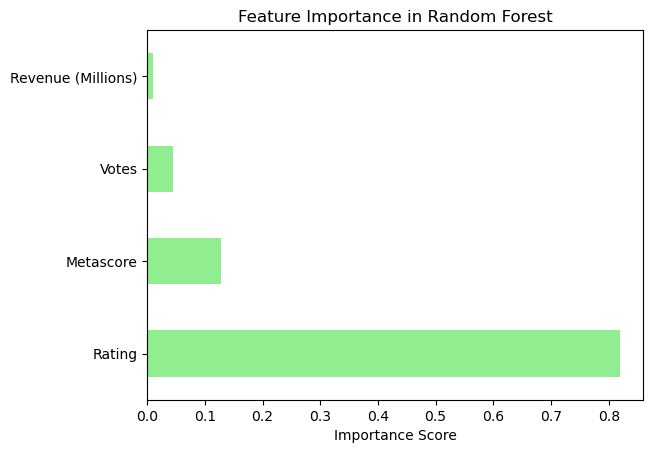

In [15]:
import matplotlib.pyplot as plt
import numpy as np

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)   ### FILL IN BLANK
importances.plot(kind='barh', color='lightgreen', title='Feature Importance in Random Forest')
plt.xlabel('Importance Score')
plt.show()


**Interpretation:**  
Which feature was most influential, and does this align with your intuition about what makes a movie successful?


# Step 7. Hyperparameter Experimentation (Group Task)

In [16]:

for n in [50, 100, 200, 300]:   ### FILL IN BLANK
    model = RandomForestClassifier(n_estimators=n, random_state=42)   ### FILL IN BLANK
    model.fit(X_train, y_train)   ### FILL IN BLANK
    preds = model.predict(X_test)   ### FILL IN BLANK
    acc = accuracy_score(y_test, preds)   ### FILL IN BLANK
    print(f"n_estimators = {n}: Accuracy = {acc:.3f}")


n_estimators = 50: Accuracy = 1.000
n_estimators = 100: Accuracy = 1.000
n_estimators = 200: Accuracy = 1.000
n_estimators = 300: Accuracy = 1.000


**Interpretation:**  
As you increase the number of trees, what trend do you observe in model accuracy and stability?


# Step 8. Visualize ROC Curve

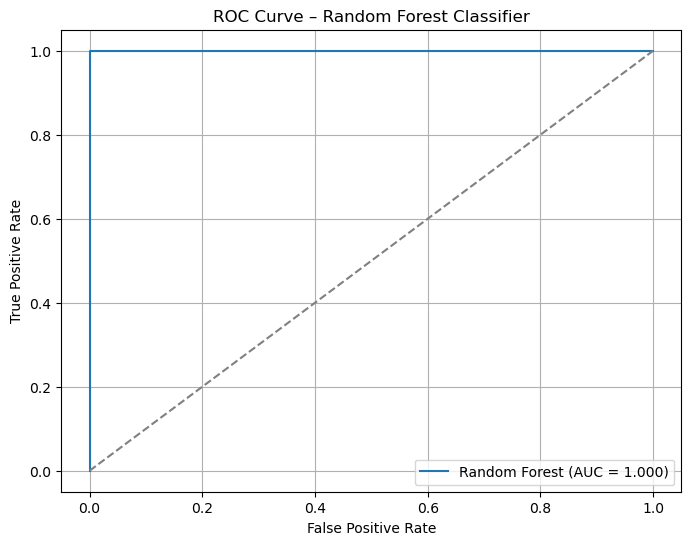

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = rf.predict_proba(X_test)[:, 1]   ### FILL IN BLANK
fpr, tpr, _ = roc_curve(y_test, y_proba)   ### FILL IN BLANK
auc = roc_auc_score(y_test, y_proba)   ### FILL IN BLANK

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest Classifier")
plt.legend()
plt.grid(True)
plt.show()



**Interpretation:**  
What does the ROC-AUC score tell you about the overall quality of your Random Forest model?


# Step 8: Reflection and Discussion

1. How does combining multiple Decision Trees improve predictive performance?  
2. Which features were most influential in predicting movie success?  
3. How does increasing the number of trees affect bias and variance?  
4. In what ways could this model be improved (e.g., adding categorical features, tuning hyperparameters)?
